In [87]:
from langchain_openai import ChatOpenAI
from typing import List , TypedDict , Literal
from dotenv import load_dotenv
import os
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.schema import HumanMessage, SystemMessage
from web_operations import weather_call, Adhan_call, wikipedia_call

In [88]:
model_name = "openai/gpt-4o-mini"
api_key = os.getenv("API_KEY")
llm = ChatOpenAI(
    model=model_name, 
    openai_api_base = "https://openrouter.ai/api/v1", 
    openai_api_key = api_key, 
    temperature = 0.7
)
print(llm.invoke("hi wsup").content)

Hey! Not much, just here to help you out. What’s up with you?


In [89]:
class Messages(TypedDict):
    role : Literal["weather", "Adhan", "Search"]
    content : str

class State(TypedDict):
    messages : List[Messages]

In [90]:
def Weather(state: State):
    """this node returns the weather info of a city"""
    last_message = state["messages"][-1]
    question = last_message["content"]
    llm_city = [
        SystemMessage(content="based on the user's question, extract the city of the user wants its weather info, return only the city like : Moscow"), 
        HumanMessage(content=question)
    ]
    city = llm.invoke(llm_city).content.strip()
    weather_info = weather_call(city)
    llm_prompt = [
        SystemMessage(content="you're an AI assistant, help the user get the weather info based on the weather api"),
        HumanMessage(content=question),
        SystemMessage(content=f"api weather results : {weather_info}")
    ]
    response = llm.invoke(llm_prompt).content
    state["messages"].append({
        "role": "Weather", 
        "content": response
    })
    # print(state["messages"][-1]["content"])
    return state

***The States***

In [91]:
def Adhan(state: State) -> State:
    """this node returns the prayer time of a given city and country"""
    last_msg = state["messages"][-1]
    question = last_msg["content"]
    city_prompt = [
        SystemMessage(content="you're an AI assistant, your job is just to return the city that the user mention in his text, return only the city with no additional text. just like : 'Madrid' or 'Marrakech', don't add any additional texts"),
        HumanMessage(content=question)
    ]
    city = llm.invoke(city_prompt).content.strip()
    country_prompt = [
        SystemMessage(content="you're an AI assistant, your job is just to return the country that the user mention in his text or from the city mentioned, return only the country with no additional text. just like : 'Germany' or 'Morocco', don't add any additional texts"),
        HumanMessage(content=question)
    ]
    country = llm.invoke(country_prompt).content.strip()
    results = Adhan_call(city=city , country=country)
    llm_prompt = [
        SystemMessage(content="you're an AI assistant, your job is to give the user a professionel answer of prayers time based on the Adhan api results"),
        HumanMessage(content=question),
        SystemMessage(content=f"the api results : {results}")
    ]
    response = llm.invoke(llm_prompt).content
    state["messages"].append({
        "role":"Adhan", 
        "content": response
    })
    # print(state["messages"][-1]["content"])
    return state

In [92]:
msg = {
    "messages":[
        {
            "role":"Adhan",
            "content":"give me the prayer times today of Barcelona city "
    }
    ]
}
x = Adhan(msg)

In [93]:
def wikipedia(state: State) -> State:
    last_msg = state["messages"][-1]
    qst = last_msg["content"]
    results = wikipedia_call(qst)
    if not isinstance(results , str):
        results = str(results)
    llm_prompt = [
        SystemMessage(content=f"""
            The user asked about a topic and you have the raw results from Wikipedia. 
            Your job is to:
            1. Summarize and organize the information clearly.
            2. Write it in a professional, easy-to-read style.
            3. Merge and enrich the response naturally with the Wikipedia content.
            4. Avoid copying text verbatim; make it coherent and concise.                      
            wikipedia results : {results}
            """),
    ]
    response = llm.invoke(llm_prompt).content
    state["messages"].append({
        "role":"Search",
        "content": response
    })
    # print(state["messages"][-1]["content"])
    return state

In [94]:
def decider(state: State):
    last_msg = state['messages'][-1]
    question = last_msg["content"]
    structured_llm = llm.with_structured_output(Messages)
    prompt = [
        SystemMessage(content="Identify if the user's question is about Weather, Adhan, or general Search. Return only the role value."),
        HumanMessage(content=question)
    ]
    output = structured_llm.invoke(prompt) 
    field = output.get("role", "Search") 

    if field.lower() == "weather":
        return {"next": "weather_node"}
    elif field.lower() == "adhan":
        return {"next": "adhan_node"}      
    else:
        return {"next": "wikipedia_node"}  

In [95]:
from langgraph.graph import StateGraph, END, START
graph_builder = StateGraph(State) 
graph_builder.add_node("adhan_node", Adhan)
graph_builder.add_node('wikipedia_node', wikipedia)
graph_builder.add_node('weather_node', Weather)
graph_builder.add_node('decider_node', decider)

graph_builder.add_edge(START, "decider_node")

# ⬇️ F hadi khassek tpassi l-functions nfsshom
graph_builder.add_conditional_edges(
    "decider_node", 
    {
        "weather": Weather,      
        "adhan": Adhan,          
        "search": wikipedia      
    }
)
graph_builder.add_edge("weather_node", END)
graph_builder.add_edge("adhan_node", END)
graph_builder.add_edge("wikipedia_node", END)

graph = graph_builder.compile()

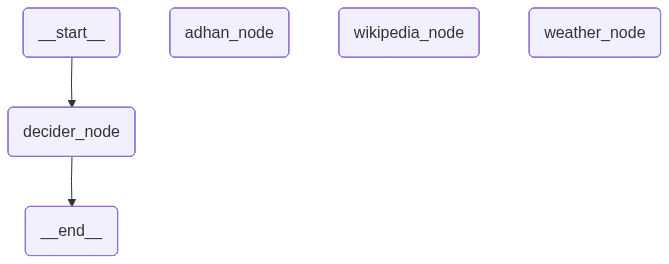

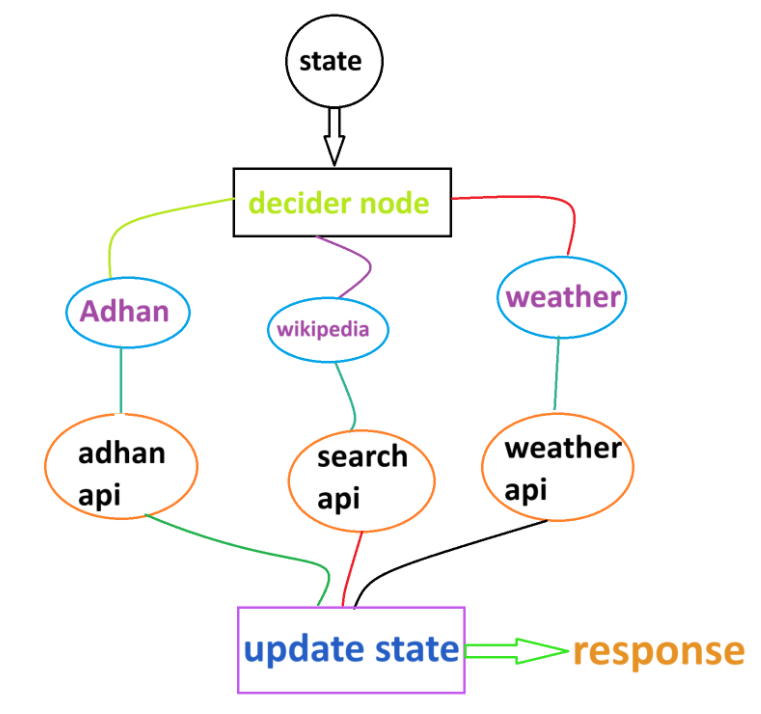

In [96]:
from IPython.display import display, Image
display(Image(graph.get_graph().draw_mermaid_png()))
display(Image(filename="mermaid.png"))

In [98]:
while True:
    user_input = input("ask AI: ")
    if user_input.lower() == "exit":
        break

    state = {"messages": [{"role":"user", "content": user_input}]}
    resp_state = graph.invoke(state)
    print(resp_state["messages"][-1]["content"])

Task decider_node with path ('__pregel_pull', 'decider_node') wrote to unknown channel branch:to:{'weather': {'next': 'weather_node', 'messages': [{'role': 'user', 'content': 'golia fo9ach ghaywdn l3assr lyoma f tinghir ?'}, {'role': 'Search', 'content': 'It appears that there is currently no information available on the specific topic you inquired about from Wikipedia. However, I can assist you with a summary or provide insights based on general knowledge up to October 2023. Please share the topic or specific questions you have in mind, and I will do my best to provide a comprehensive and informative response.'}, {'role': 'Weather', 'content': "L'yoma f Tinghir, l'jaw f'na, kayn chwiya dyal lghaym, w lharara hiya 23.12°C. Makhassakch tkhaf mn l3assr, ma kaynach malayin dyal lma."}, {'role': 'Adhan', 'content': "L'Adhan pour l'Asr aujourd'hui à Tinghir est à 16:20."}]}, 'adhan': {'next': 'weather_node', 'messages': [{'role': 'user', 'content': 'golia fo9ach ghaywdn l3assr lyoma f tingh

L'Adhan pour l'Asr aujourd'hui à Tinghir est à 16:20.


In [ ]:
import streamlit as st


st.set_page_config(page_title="LangGraph AI Chat", page_icon="🤖")
st.title("🤖 LangGraph AI Chat")

if "state" not in st.session_state:
    st.session_state.state = {"messages": []}

st.sidebar.header("Instructions")
st.sidebar.write("Type your question in the input box below and press Enter. Type 'exit' to reset.")

user_input = st.text_input("Ask AI:")

if user_input:
    if user_input.lower() == "exit":
        st.session_state.state = {"messages": []}  # Reset conversation
        st.experimental_rerun()

    st.session_state.state["messages"].append({"role":"user", "content": user_input})

    resp_state = graph.invoke(st.session_state.state)

    ai_response = resp_state["messages"][-1]["content"]
    st.session_state.state["messages"].append({"role":"AI", "content": ai_response})

for msg in st.session_state.state["messages"]:
    if msg["role"] == "user":
        st.markdown(f"**You:** {msg['content']}")
    else:
        st.markdown(f"**AI:** {msg['content']}")


2025-10-20 10:56:37.159 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-20 10:56:37.160 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-20 10:56:37.570 
  command:

    streamlit run c:\Users\lenovo\AppData\Local\Programs\Python\Python313\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-10-20 10:56:37.572 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-20 10:56:37.573 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-20 10:56:37.574 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-20 10:56:37.576 Session state does not function when running a script